# Прогнозирование качества вина (мультиклассовая классификация)

**Описание задачи**

Необходимо построить ML-модель с наиболее высокими метриками качества по прогнозу качества вина на основе его характеристик.

**Описание данных**

Data frame содержит следующие столбцы:<br>
- Признаки на основе физико-химических испытаний: <br>
1 - fixed acidity (фиксированная кислотность)<br>
2 - volatile acidity (летучая кислотность)<br>
3 - citric acid (лимонная кислота)<br>
4 - residual sugar (остаточный сахар)<br>
5 - chlorides (хлориды)<br>
6 - free sulfur dioxide (свободный диоксид серы)<br>
7 - total sulfur dioxide (общий диоксид серы)<br>
8 - density (плотность)<br>
9 - pH (кислотность pH)<br>
10 - sulphates (сульфаты)<br>
11 - alcohol (содержание спирта)<br>
- Целевой признак на основе сенсорных данных:<br>
12 - quality (качество, оценка от 0 до 10)

## Загрузка и подготовка данных

Импортируем библиотеки и функции, используемые в проекте:

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

### Загрузка и предварительный анализ данных

Прочитаем файл 'WineQT.csv' и сохраним его в переменной df:

In [2]:
df = pd.read_csv('WineQT.csv', sep=',')

Выведем на экран общую информацию, первые 5 строк и числовое описание данных для числовых столбцов таблицы:

In [3]:
df.info()
display(df.head())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


### Приведение наименований столбцов к змеиному регистру

В связи с тем, что наименования столбцов датафреймов не соответствуют змеиному регистру (стандарт PEP), требуется их переименование для приведения к змеиному регистру.

Создадим функцию для изменения имени столбца в соответствии со змеиным регистром, затем осуществим приведение столбцов датафреймов к змеиному регистру и проверим результат с помощью вывода на экран перечня столбцов:

In [4]:
def column_name_to_snake(column_name: str):
    str_tmp = re.sub('([a-z])([A-Z0-9])', r'\1_\2', column_name).lower()
    return re.sub(r'[^a-zA-Z0-9]', '_', str_tmp)

In [5]:
for col_name in df.columns:
    df = df.rename(columns={col_name: column_name_to_snake(col_name)})
df = df.rename(columns={'p_h': 'pH'})

In [6]:
print('Датафрейм df:', df.columns)

Датафрейм df: Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'id'],
      dtype='object')


### Анализ данных на мультиколлинеарность факторов

**Проверим в каких столбцах данные имеют сильную взаимосвязь.**

Построим матрицу корреляции для числовых столбцов таблицы:

In [7]:
corr_matrix = df.drop(['id'], axis=1).corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
fixed_acidity,1.000000,-0.271630,0.645495,0.234454,0.206700,-0.144265,-0.082924,0.605426,-0.686997,0.156965,-0.070238,0.113726
volatile_acidity,-0.271630,1.000000,-0.625896,0.018466,0.115893,-0.021908,0.108518,0.041507,0.209666,-0.335096,-0.214808,-0.365016
citric_acid,0.645495,-0.625896,1.000000,0.175134,0.082674,-0.057498,0.004774,0.290172,-0.462926,0.260189,0.131848,0.240630
residual_sugar,0.234454,0.018466,0.175134,1.000000,0.212885,0.045647,0.174976,0.393467,-0.049982,0.040617,0.097756,-0.003214
chlorides,0.206700,0.115893,0.082674,0.212885,1.000000,0.019034,0.181275,0.402707,-0.175666,-0.079461,-0.310635,-0.179333
free_sulfur_dioxide,-0.144265,-0.021908,-0.057498,0.045647,0.019034,1.000000,0.607067,-0.042393,0.113060,0.070391,-0.010977,-0.006254
total_sulfur_dioxide,-0.082924,0.108518,0.004774,0.174976,0.181275,0.607067,1.000000,0.144131,0.005942,-0.061357,-0.242304,-0.204686
density,0.605426,0.041507,0.290172,0.393467,0.402707,-0.042393,0.144131,1.000000,-0.206025,0.085639,-0.553324,-0.235929
pH,-0.686997,0.209666,-0.462926,-0.049982,-0.175666,0.113060,0.005942,-0.206025,1.000000,0.038215,0.143171,-0.068512
sulphates,0.156965,-0.335096,0.260189,0.040617,-0.079461,0.070391,-0.061357,0.085639,0.038215,1.000000,0.253168,0.418643


Построим диаграмму рассеяния для столбцов 'density' и 'fixed acidity' таблицы:

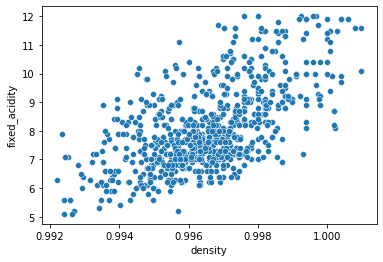

In [8]:
sns.scatterplot(x=df['density'], y=df['fixed_acidity'])
plt.show()

### Подготовка выборок для обучения и оценки качества ML-модели

Создадим функцию для разделения исходных данных на 2 выборки: обучающую (75%) и тестовую (25%):

In [9]:
def f_data_split_train_valid_test(f_df):
    #функция для разделения исходных данных на обучающую (75%) и тестовую (25%) выборки
    
    #Разобъем исходную таблицу на две: целевой признак и остальные признаки
    f_df_features = f_df.drop(['id', 'quality'], axis=1)
    f_df_target = f_df['quality']
    #Выделим обучающую (75%) и тестовую (25%) выборки из общего набора данных
    f_features_train, f_features_test, f_target_train, f_target_test = train_test_split(
        f_df_features, f_df_target, test_size=0.25, random_state=177523)
    f_features_train = f_features_train.reset_index(drop=True)
    f_features_test = f_features_test.reset_index(drop=True)
    f_target_train = f_target_train.reset_index(drop=True)
    f_target_test = f_target_test.reset_index(drop=True)
    
    return f_features_train, f_features_test, f_target_train, f_target_test

Выделим обучающую и тестовую выборки из общего набора данных:

In [10]:
features_train, features_test, target_train, target_test = f_data_split_train_valid_test(df)

**Баланс классов:**

In [11]:
print(df['quality'].value_counts(normalize=True).sort_index(), '\n')

3    0.003534
4    0.022379
5    0.425206
6    0.424028
7    0.111896
8    0.012956
Name: quality, dtype: float64 



### Вывод раздела

1. Для проекта подготовлен dataframe, который содержит 1143 записи.
2. Анализ данных показывает, что во всех столбцах dataframe присутствуют выбросы за границами нормального распределения.
3. Мультиколлинеарность (сильная зависимость) между столбцами dataframe отсутствует (максимальная зависимость - около 60%).
4. В dataframe выявлено 6 классов (3 - 8), присутствует дисбаланс классов.

## Обучение и оценка качества прогнозирования ML-моделей

Создадим функцию для обучения одной из 4-х моделей («логистическая регрессия», «градиентный бустинг» библиотек XGBoost, LightGBM и CatBoost), расчета метрик модели и констатной модели:

In [12]:
warnings.filterwarnings('ignore')
df_metrics = pd.DataFrame(data=[['CatBoostClassifier', np.nan, np.nan, np.nan, np.nan],
                                ['LGBMClassifier', np.nan, np.nan, np.nan, np.nan],
                                ['XGBClassifier', np.nan, np.nan, np.nan, np.nan],
                                ['LogisticRegression', np.nan, np.nan, np.nan, np.nan],
                                ['Constant model', np.nan, np.nan, np.nan, np.nan]],
                      columns=['Model', 'Accuracy', 'F1-score', 'Precision', 'Recall'])

def f_4ML_models_metrics(fv_features_train: pd.DataFrame, fv_target_train: pd.Series,
                         fv_features_test: pd.DataFrame, fv_target_test: pd.Series,
                         fv_modelname: str, fv_max_estimators=400, fv_max_depth=None, fv_learning_rate=0.1,
                         fv_class_weight='balanced'):
    #функция для обучения и расчета метрик ML-моделей
    
    #определим одну из ML-моделей
    if fv_modelname == 'XGBClassifier':
        model = XGBClassifier(random_state=177523, n_estimators=fv_max_estimators, max_depth=fv_max_depth,
                              learning_rate=fv_learning_rate, verbosity=0)
    elif fv_modelname == 'LGBMClassifier':
        model = LGBMClassifier(random_state=177523, n_estimators=fv_max_estimators, max_depth=fv_max_depth,
                               class_weight=fv_class_weight, learning_rate=fv_learning_rate)
    elif fv_modelname == 'CatBoostClassifier':
        model = CatBoostClassifier(random_state=177523, iterations=fv_max_estimators, depth=fv_max_depth,
                                   learning_rate=fv_learning_rate)
    elif fv_modelname == 'LogisticRegression':
        model = LogisticRegression(random_state=177523, solver='liblinear', class_weight=fv_class_weight)
    else:
        #Константная модель
        model = DummyClassifier(strategy='stratified')
    #обучим модель
    if fv_modelname == 'CatBoostClassifier':
        model.fit(fv_features_train, fv_target_train, verbose=False)
    else:
        model.fit(fv_features_train, fv_target_train)
    #вычислим метрику
    predict_test = model.predict(fv_features_test)
    classification_rep = classification_report(fv_target_test, predict_test)
    classification_rep_dict = classification_report(fv_target_test, predict_test, output_dict=True)
    #сохраним значения метрик для модели и константной модели
    df_metrics.loc[df_metrics['Model']==fv_modelname, 'Accuracy'] = classification_rep_dict.get('accuracy')
    df_metrics.loc[df_metrics['Model']==fv_modelname, 'F1-score'] = classification_rep_dict.get('weighted avg').\
                                                                                            get('f1-score')
    df_metrics.loc[df_metrics['Model']==fv_modelname, 'Precision'] = classification_rep_dict.get('weighted avg').\
                                                                                             get('precision')
    df_metrics.loc[df_metrics['Model']==fv_modelname, 'Recall'] = classification_rep_dict.get('weighted avg').\
                                                                                          get('recall')
    
    return classification_rep, df_metrics

### Обучение и оценка качества модели «градиентный бустинг» библиотеки CatBoost

In [13]:
classification_rep, df_metrics = f_4ML_models_metrics(features_train, target_train, features_test, target_test,
                                                      'CatBoostClassifier', 793, 10, 0.01)
print('Отчет по классификации модели CatBoostClassifier:\n', classification_rep)

Отчет по классификации модели CatBoostClassifier:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           5       0.79      0.79      0.79        90
           6       0.76      0.77      0.76        99
           7       0.65      0.75      0.70        20
           8       0.00      0.00      0.00         1

    accuracy                           0.76       213
   macro avg       0.37      0.38      0.38       213
weighted avg       0.75      0.76      0.75       213



### Обучение и оценка качества модели «градиентный бустинг» библиотеки LightGBM

In [14]:
classification_rep, df_metrics = f_4ML_models_metrics(features_train, target_train, features_test, target_test, 
                                                      'LGBMClassifier', 770, 15, 0.01)
print('Отчет по классификации модели LGBMClassifier:\n', classification_rep)

Отчет по классификации модели LGBMClassifier:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           5       0.71      0.67      0.69        90
           6       0.69      0.68      0.68        99
           7       0.52      0.70      0.60        20
           8       0.00      0.00      0.00         1

    accuracy                           0.66       213
   macro avg       0.32      0.34      0.33       213
weighted avg       0.67      0.66      0.66       213



### Обучение и оценка качества модели «градиентный бустинг» библиотеки XGBoost

In [15]:
classification_rep, df_metrics = f_4ML_models_metrics(features_train, target_train, features_test, target_test, 
                                                      'XGBClassifier', 50, 16, 0.01)
print('Отчет по классификации модели XGBClassifier:\n', classification_rep)

Отчет по классификации модели XGBClassifier:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           5       0.79      0.73      0.76        90
           6       0.70      0.75      0.72        99
           7       0.45      0.45      0.45        20
           8       0.00      0.00      0.00         1

    accuracy                           0.70       213
   macro avg       0.32      0.32      0.32       213
weighted avg       0.70      0.70      0.70       213



### Обучение и оценка качества модели «логистическая регрессия»

In [16]:
classification_rep, df_metrics = f_4ML_models_metrics(features_train, target_train, features_test, target_test,
                                                      'LogisticRegression')
print('Отчет по классификации модели LogisticRegression:\n', classification_rep)

Отчет по классификации модели LogisticRegression:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           5       0.64      0.60      0.62        90
           6       0.66      0.44      0.53        99
           7       0.35      0.65      0.46        20
           8       0.00      0.00      0.00         1

    accuracy                           0.52       213
   macro avg       0.28      0.28      0.27       213
weighted avg       0.61      0.52      0.55       213



### Оценка качества констатной модели

In [17]:
classification_rep, df_metrics = f_4ML_models_metrics(features_train, target_train, features_test, target_test,
                                                      'Constant model')
print('Отчет по классификации Константной модели:\n', classification_rep)

Отчет по классификации Константной модели:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           5       0.50      0.53      0.52        90
           6       0.50      0.41      0.45        99
           7       0.04      0.05      0.05        20
           8       0.00      0.00      0.00         1

    accuracy                           0.42       213
   macro avg       0.17      0.17      0.17       213
weighted avg       0.45      0.42      0.43       213



## Общий вывод

In [18]:
display(df_metrics)

,Model,Accuracy,F1-score,Precision,Recall
0,CatBoostClassifier,0.760563,0.753857,0.747810,0.760563
1,LGBMClassifier,0.661972,0.663441,0.667987,0.661972
2,XGBClassifier,0.699531,0.698352,0.698721,0.699531
3,LogisticRegression,0.521127,0.551487,0.609855,0.521127
4,Constant model,0.422535,0.433017,0.447744,0.422535


**По результатам проекта можно сделать следующие выводы:**
1. Лучшей моделью для прогнозирования качества вина по характеристикам является «градиентный бустинг» библиотеки CatBoost. Значения метрик: accuracy = 0.76, f1-score = 0.75, precision = 0.75, recall = 0.76.
2. Наиболее важными факторами, влияющими на качество модели, являются alcohol (содержание спирта), sulphates (сульфаты) и volatile acidity (летучая кислотность).
3. ML-модель «градиентный бустинг» библиотеки CatBoost осуществляет прогнозирование гораздо лучше константной модели, поэтому применение указанной модели является оправданным для бизнеса и модель может быть внедрена в промышленную эксплуатацию.
4. На основе данной модели предприятия, осуществляющие производство и разработку новых марок вина, смогут повысить качество своей продукции, увеличить объемы продаж, сократить издержки, а также вывести определенные марки вина в элитную категорию.